# Radon transform

The general Radon transform is expressed as
\begin{equation}
\label{eq:general}
\begin{split}
\tilde{m}(\tau,p) &= \int d(t=\phi(\tau,h,p),h) dh, \\
d(t,h) &= \int m(\tau=\tilde{\phi}(t,h,p),p) dp,
\end{split}
\end{equation}
with $\phi(\tau,h,p)$ called the kernel functions. By choosing different kernel functions, the Radon transform can be categorized into linear, parabolic, hyperbolic Radon transform. 

Linear Radon transform
\begin{equation}
\label{eq:li}
\begin{split}
\tilde{m}(\tau,p) &= \sum_{h} d(t=\tau+ph,h) \\
d(t,h) &= \sum_{p} m(\tau=t-ph,p) 
\end{split}
\end{equation}

Parabolic Radon transform
\begin{equation}
\label{eq:para}
\begin{split}
\tilde{m}(\tau,p) &= \sum_{h} d(t=\tau+ph^2,h) \\
d(t,h) &= \sum_{p} m(\tau=t-ph^2,p) 
\end{split}
\end{equation}

Hyperbolic Radon transform
\begin{equation}
\label{eq:hyp}
\begin{split}
\tilde{m}(\tau,p) &= \sum_{h} d(t=\sqrt{\tau^2+\frac{h^2}{p^2}},h), \\
d(t,h) &= \sum_{p} m(\tau=\sqrt{t^2-\frac{h^2}{p^2}},p), 
\end{split}
\end{equation}


References:

Sacchi, M. D., & Ulrych, T. J. (1995). High-resolution velocity gathers and offset space reconstruction. Geophysics, 60(4), 1169-1177.

Chen, Y., 2018. Automatic velocity analysis using high-resolution hyperbolic Radon transform. Geophysics, 83(4), pp.A53-A57.

Zhang, Q., Chen, Y., Zhang, F. and Chen, Y., 2022. Improving receiver function imaging with high-resolution Radon transform. Geophysical Journal International, 230(2), pp.1292-1304.


# 2. Parabolic Radon transform

In [1]:
import pyradon as pr
def demultiple_radon(d,dt,h,qmin,qmax,nq,N1,N2,q_cut):
    '''
    Multiple removal using parabolic Radon transform
    
    Reference: 
    Hampson, D., 1986, Inverse velocity stacking for multiple elimination, Journal of the CSEG, vol 22, no 1., 44-55.
    '''
    
    [nt,nx]=d.shape;
    dq=(qmax-qmin)/(nq-1);
    q=np.linspace(0,nq-1,nq)*dq+qmin;
    
    par={'typ':2,'h':h.flatten(),'v':q,'dt':dt,'nt':nt}
    print('d shape',d.shape)
    print('v shape',q.shape)
    print('h shape',h.shape)
    print('nt,nq',nt,nq)
    m=pr.radon_l1c(par,d,np.zeros([nt,nq]),N1,N2,0)[0];
    
    nq=len(q);
    iq_cut=np.int32(np.floor((q_cut-qmin)/dq)+1);
    mc=m.copy();
    
    mc[:,0:iq_cut+1]=0; #Keep multiples in the Radon panel
    
    dm=pr.radonc(mc,par,1);
    
    prim=d-dm;
    
    tau=np.linspace(0,nt-1,nt)*dt;
    
    
    return prim,m
    


# Synthetic data example

In [5]:
import numpy as np
import scipy.io
# Please download data from https://github.com/chenyk1990/smalldata/blob/main/demul_syndata.mat
data=scipy.io.loadmat('demul_syndata.mat')
D=data['D']
dt=data['dt']
h=data['h']
[nt,nx]=D.shape;
t=np.linspace(1,nt,nt)*dt;

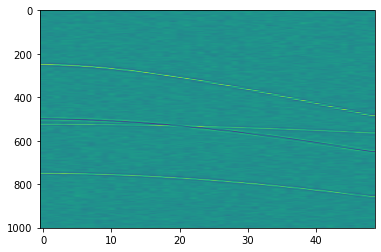

In [6]:
import matplotlib.pyplot as plt
plt.figure;
plt.imshow(D,aspect='auto')

In [7]:
import numpy as np
from scipy.interpolate import interp1d

def nmo(d,dt,h,tnmo,vnmo,max_stretch):
    [nt,nh]=d.shape;
    
    mute_count=np.zeros(nt);
    
    N=len(vnmo);
    
    if N>1:  
        t1=np.zeros(N+2);print(t1.shape)
        t1[0]=0;t1[1:-1]=tnmo;t1[-1]=(nt-1)*dt;
        print(t1.shape)
        v1=np.zeros(N+2);v1[0]=vnmo[0];v1[1:-1]=vnmo;v1[-1]=vnmo[-1];
        
        ti=np.linspace(0,nt-1,nt)*dt;
        

        print(ti.shape)
        print('ti',ti.shape,ti.flatten().shape)
        
        f=interp1d(t1, v1, kind='cubic');
        vi=f(ti)
        ti=ti.flatten();
        vi=vi.flatten();
        
    else:
        ti=np.linspace(0,nt-1,nt)*dt;
        vi=np.ones(nt)*vnmo;
    
    print(ti.shape,vi.shape)
    
    
    dout=np.zeros(d.shape);
    M=np.zeros(nt);
    
    h=h.flatten()
    for it in range(0,nt):
        for ih in range(0,nh):
            arg = ti[it]*ti[it] + (h[ih]/vi[it])*(h[ih]/vi[it])   ;
            
            time=np.sqrt(arg);
 
            stretch=(time-ti[it])/(ti[it]+1e-10);
            
            if stretch < max_stretch/100:
                M[it] = M[it] + 1;
                its=time/dt+1;
                it1=np.int32(np.floor(time/dt));
                it2=it1+1;
                a=its-it1;
                
                if it2<=nt-1:
                    dout[it,ih] = (1-a)*d[it1,ih] + a*d[it2,ih]
                
    return dout
              

In [8]:
# apply NMO

tnmo=np.array([1,2]);
vnmo=np.array([1500,3000]);
max_stretch=15;

D1=nmo(D,dt,h,tnmo,vnmo,max_stretch);




(4,)
(4,)
(1, 1001)
ti (1, 1001) (1001,)
(1001,) (1001,)


In [9]:
qmin = -0.2;
qmax = 0.8;
nq = 60;
q_cut =0.05;
N1=20;
N2=3; # sparsity constraint
D1p,M=demultiple_radon(D1,dt,h,qmin,qmax,nq,N1,N2,q_cut);

d shape (1001, 49)
v shape (60,)
h shape (1, 49)
nt,nq 1001 60


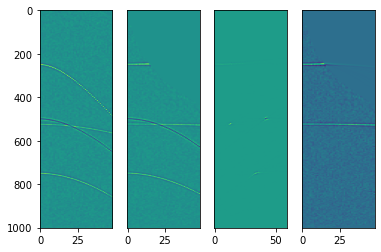

In [10]:
import matplotlib.pyplot as plt
plt.figure;
plt.subplot(1,4,1)
plt.imshow(D,aspect='auto')
plt.subplot(1,4,2)
plt.imshow(D1,aspect='auto');plt.gca().set_yticks([]);
plt.subplot(1,4,3)
plt.imshow(M,aspect='auto');plt.gca().set_yticks([]);
plt.subplot(1,4,4)
plt.imshow(D1p,aspect='auto');plt.gca().set_yticks([]);

# Field data example

In [11]:
import numpy as np
import scipy.io
# Please download data from https://github.com/chenyk1990/smalldata/blob/main/demul_field.mat
data=scipy.io.loadmat('demul_field.mat')
D=data['D']
dt=data['dt']
h=data['h']
[nt,nx]=D.shape;

D = D[800:1201,:];
    

d shape (401, 92)
v shape (120,)
h shape (1, 92)
nt,nq 401 120


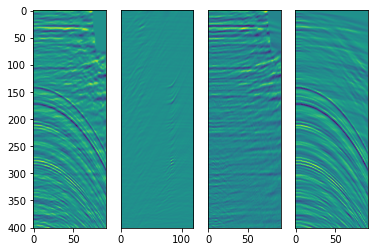

In [22]:
qmin = -0.3;
qmax = .8;
nq = 120;
flow = 2.;
fhigh = 90;
mu = 0.1;
q_cut = 0.025;
N1=20;
N2=1;
P,M = demultiple_radon(D,dt,h,qmin,qmax,nq,N1,N2,q_cut);

# demultiple_radon(D1,dt,h,qmin,qmax,nq,N1,N2,q_cut);

import matplotlib.pyplot as plt
plt.figure;
plt.subplot(1,4,1)
plt.imshow(D,aspect='auto')
plt.subplot(1,4,2)
plt.imshow(M,aspect='auto',clim=[-1,1]);plt.gca().set_yticks([]);
plt.subplot(1,4,3)
plt.imshow(P,aspect='auto');plt.gca().set_yticks([]);
plt.subplot(1,4,4)
plt.imshow(D-P,aspect='auto');plt.gca().set_yticks([]);

In [13]:
M.max()

0.69477797